Flexible Theory of Mind Implementation with arbitrary number of characters and global + local context graphs

Steps: Just run the two blocks - associated code in tom.py and global_graph.ipynb

Global Context Graph:


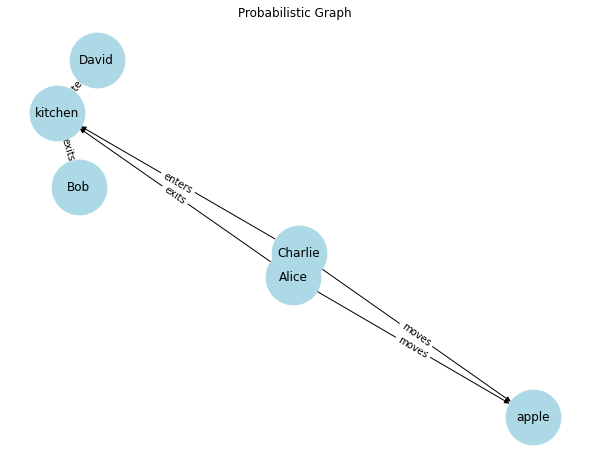

Local Context Graphs:
Alice's Local Context Graph:


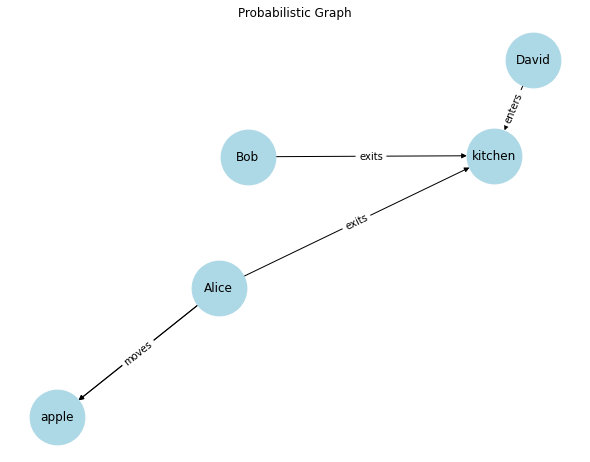

Bob's Local Context Graph:


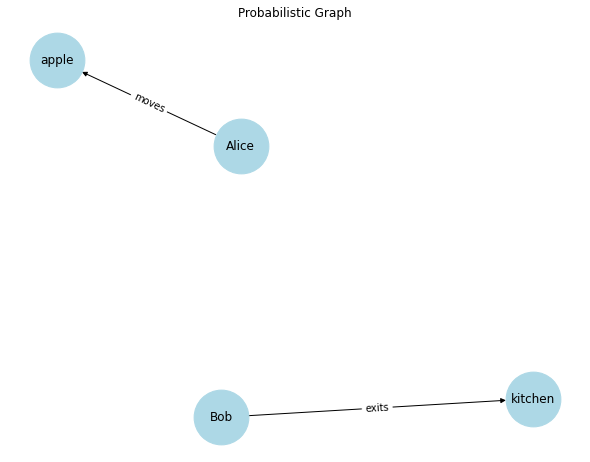

David's Local Context Graph:


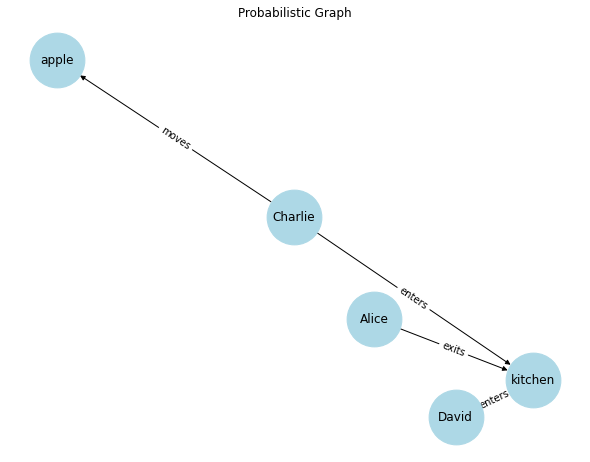

Charlie's Local Context Graph:


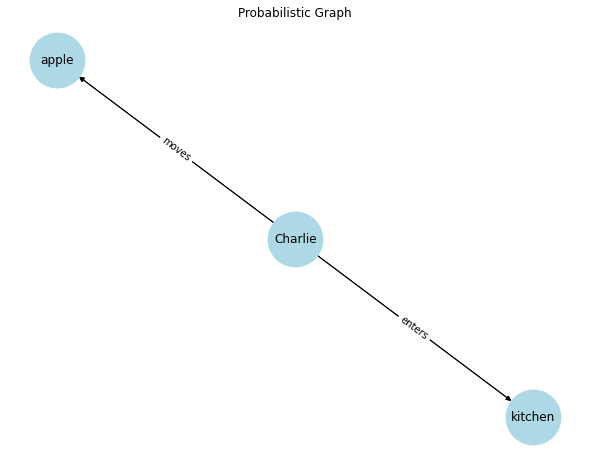

In [3]:
# Local and Global Contexts with flexible number of characters

from tom import ProbabilisticGraphsContainer, update_local_contexts, extract_characters, update_global_and_extract_svo, ProbabilisticGraph

story_sentences = [
    "Alice and Bob are in the kitchen.",
    "The apple is in the basket.",
    "The basket is in the kitchen.",
    "Alice moves the apple to the fridge.",
    "The fridge is in the kitchen.",
    "Bob exits the kitchen.",
    "David enters the kitchen.",
    "Alice exits the kitchen.",
    "Charlie enters the kitchen.",
    "Charlie moves the apple to the cupboard.",
    "The cupboard is in the kitchen."
]

global_context = ProbabilisticGraph()
update_global_and_extract_svo(global_context, story_sentences)

local_contexts = ProbabilisticGraphsContainer()

update_local_contexts(global_context, local_contexts, story_sentences)

print("Global Context Graph:")
global_context.draw_graph()

print("Local Context Graphs:")
for character, local_context in local_contexts.local_contexts.items():
    print(f"{character}'s Local Context Graph:")
    local_context.draw_graph()

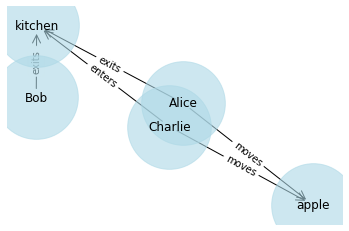

In [5]:
# Simple Global Graph Code
from global_graph import ProbabilisticGraph, update_global_context

story_sentences = [
    "Alice and Bob are in the kitchen.",
    "The apple is in the basket.",
    "The basket is in the kitchen.",
    "Alice moves the apple to the fridge.",
    "The fridge is in the kitchen.",
    "Bob exits the kitchen.",
    "Alice exits the kitchen.",
    "Charlie enters the kitchen.",
    "Charlie moves the apple to the cupboard.",
    "The cupboard is in the kitchen."
]

global_context = ProbabilisticGraph()
update_global_context(global_context, story_sentences)

global_context.draw_graph()

Global Context Graph:


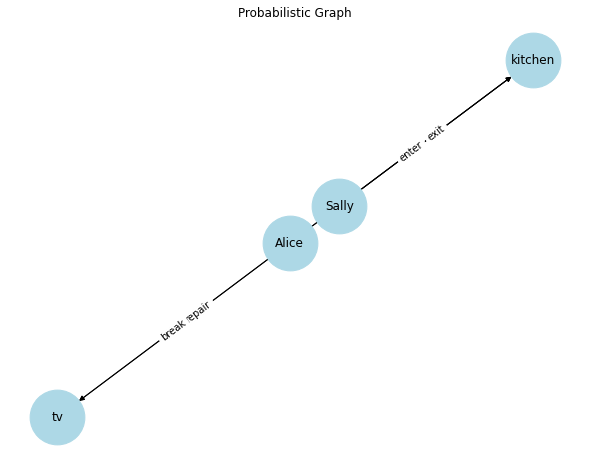

Local Context Graphs:
Sally's Local Context Graph:


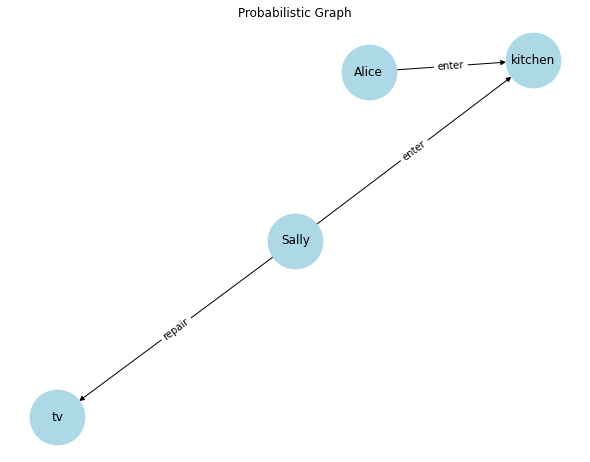

Alice's Local Context Graph:


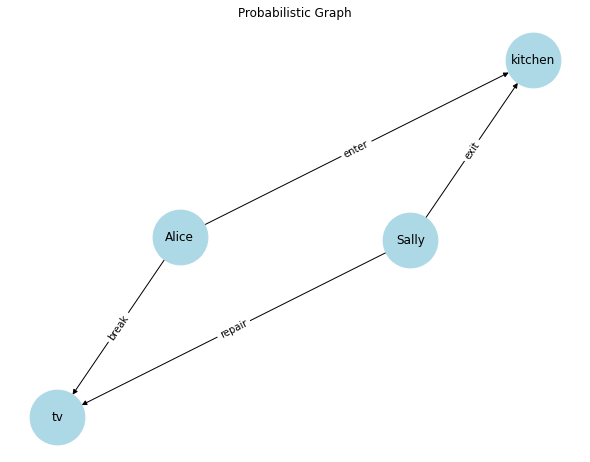

First-Order Beliefs:
Sally's Beliefs:
- Sally believes that Sally enter kitchen
- Sally believes that Alice enter kitchen
- Sally believes that Sally repair tv

Alice's Beliefs:
- Alice believes that Alice enter kitchen
- Alice believes that Sally repair tv
- Alice believes that Sally exit kitchen
- Alice believes that Alice break tv

Second-Order Beliefs:
Sally's Second-Order Beliefs:
- Sally believes that Alice believes that Alice enter kitchen
- Sally believes that Alice believes that Sally repair tv

Alice's Second-Order Beliefs:
- Alice believes that Sally believes that Alice enter kitchen
- Alice believes that Sally believes that Sally repair tv



In [67]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict

nlp = spacy.load("en_core_web_sm")

class ProbabilisticGraph:
    def __init__(self):
        self.graph = nx.MultiDiGraph()

    def add_edges_from_svo(self, svo_triples):
        for s, v, o in svo_triples:
            self.graph.add_edge(s, o, relation=v)

    def extract_svo_triples(self, sentence):
        doc = nlp(sentence)
        svo_triples = []
        for token in doc:
            if token.dep_ in ["nsubj", "nsubjpass"]:
                subject = token.text
                verb = token.head.lemma_ 
                for child in token.head.children:
                    if child.dep_ in ["dobj", "pobj", "attr", "oprd"]:
                        object = child.text
                        svo_triples.append((subject, verb, object))
        return svo_triples

    def draw_graph(self):
        pos = nx.spring_layout(self.graph)
        plt.figure(figsize=(8, 6))
        nx.draw(self.graph, pos, with_labels=True, node_size=3000, node_color='lightblue', arrows=True)
        edge_labels = {(u, v): d['relation'] for u, v, d in self.graph.edges(data=True)}
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels)
        plt.title("Probabilistic Graph")
        plt.axis('off')
        plt.show()

    def infer_beliefs(self, character):
        beliefs = []
        for s, o, d in self.graph.edges(data=True):
            if s.lower() == character.lower():
                belief = f"{character} believes that {s} {d['relation']} {o}"
                beliefs.append(belief)
        return beliefs

class ProbabilisticGraphsContainer:
    def __init__(self):
        self.global_context = ProbabilisticGraph()
        self.local_contexts = {}
        self.character_presence = {}
        self.character_observations = {}

    def add_character(self, character):
        self.local_contexts.setdefault(character, ProbabilisticGraph())
        self.character_presence.setdefault(character, False)
        self.character_observations.setdefault(character, [])

    def set_character_presence(self, character, present=True):
        self.character_presence[character] = present

    def update_global_context(self, sentence):
        svo_triples = self.global_context.extract_svo_triples(sentence)
        self.global_context.add_edges_from_svo(svo_triples)

    def update_local_contexts(self, sentence, present_characters):
        svo_triples = self.global_context.extract_svo_triples(sentence)
        for character in present_characters:
            if self.character_presence[character]:
                local_context = self.local_contexts[character]
                local_context.add_edges_from_svo(svo_triples)
                for triple in svo_triples:
                    if triple not in self.character_observations[character]:
                        self.character_observations[character].append(triple)

    def infer_beliefs(self, character):
        beliefs = []
        observed_triples = self.character_observations[character]
        for s, v, o in observed_triples:
            belief = f"{character} believes that {s} {v} {o}"
            beliefs.append(belief)
        return beliefs

    def infer_second_order_beliefs(self, character):
        second_order_beliefs = []
        for other_character in self.local_contexts:
            if other_character != character:
                for s, v, o in self.character_observations[other_character]:
                    if (s, v, o) in self.character_observations[character]:
                        belief = f"{other_character} believes that {s} {v} {o}"
                        second_order_belief = f"{character} believes that {belief}"
                        second_order_beliefs.append(second_order_belief)
        return second_order_beliefs

def extract_characters(sentence):
    doc = nlp(sentence)
    characters = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            characters.append(ent.text)
    return characters

def process_story(story_sentences):
    container = ProbabilisticGraphsContainer()
    present_characters = set()

    for sentence in story_sentences:
        characters = extract_characters(sentence)

        for character in characters:
            container.add_character(character)
            if "enters" in sentence.lower():
                container.set_character_presence(character, True)
                present_characters.add(character)
            elif "exits" in sentence.lower():
                container.set_character_presence(character, False)
                present_characters.discard(character)

        container.update_global_context(sentence)
        container.update_local_contexts(sentence, present_characters)

    return container

story_sentences = [
    "Sally enters the kitchen.",
    "Alice enters the kitchen.",
    "Sally repairs the tv.",
    "Sally exits the kitchen.",
    "Alice breaks the tv.",
]

container = process_story(story_sentences)

print("Global Context Graph:")
container.global_context.draw_graph()

print("Local Context Graphs:")
for character, local_context in container.local_contexts.items():
    print(f"{character}'s Local Context Graph:")
    local_context.draw_graph()

print("First-Order Beliefs:")
for character in container.local_contexts:
    beliefs = container.infer_beliefs(character)
    print(f"{character}'s Beliefs:")
    for belief in beliefs:
        print(f"- {belief}")
    print()

print("Second-Order Beliefs:")
for character in container.local_contexts:
    second_order_beliefs = container.infer_second_order_beliefs(character)
    print(f"{character}'s Second-Order Beliefs:")
    for belief in second_order_beliefs:
        print(f"- {belief}")
    print()

Global Context Graph:
SVO Triples in the Global Context:
- Sally enter kitchen
- Sally exit kitchen
- Sally repair tv
- Alice enter kitchen
- Alice break tv


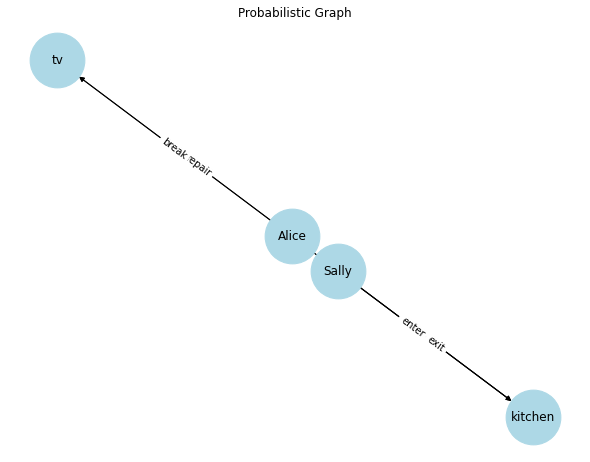


Local Context Graphs:
Sally's Local Context Graph:
SVO Triples in Sally's Local Context:
- Sally enter kitchen
- Sally repair tv
- Alice enter kitchen


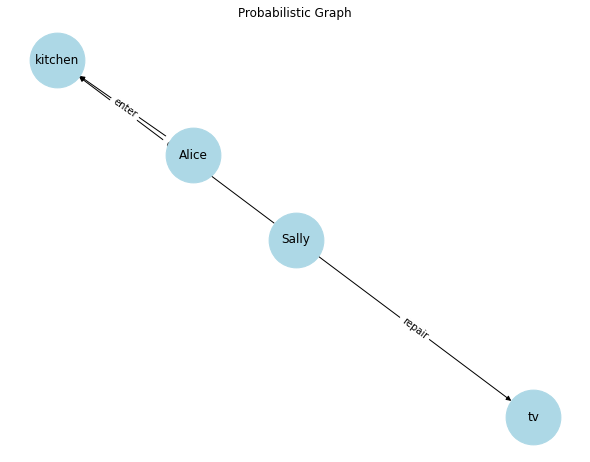

Alice's Local Context Graph:
SVO Triples in Alice's Local Context:
- Alice enter kitchen
- Alice break tv
- Sally repair tv
- Sally exit kitchen


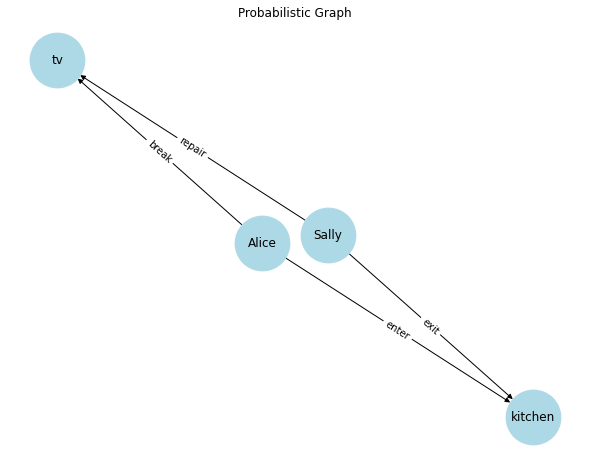


First-Order Beliefs:
Sally's Beliefs:
- Sally believes that Sally enter kitchen
  - SVO Triple: Sally enter kitchen
- Sally believes that Alice enter kitchen
  - SVO Triple: Alice enter kitchen
- Sally believes that Sally repair tv
  - SVO Triple: Sally repair tv

Alice's Beliefs:
- Alice believes that Alice enter kitchen
  - SVO Triple: Alice enter kitchen
- Alice believes that Sally repair tv
  - SVO Triple: Sally repair tv
- Alice believes that Sally exit kitchen
  - SVO Triple: Sally exit kitchen
- Alice believes that Alice break tv
  - SVO Triple: Alice break tv

Second-Order Beliefs:
Sally's Second-Order Beliefs:
- Sally believes that Alice believes that Alice enter kitchen
  - SVO Triple: Alice enter kitchen
- Sally believes that Alice believes that Sally repair tv
  - SVO Triple: Sally repair tv

Alice's Second-Order Beliefs:
- Alice believes that Sally believes that Alice enter kitchen
  - SVO Triple: Alice enter kitchen
- Alice believes that Sally believes that Sally repair 

In [3]:
# Code for Bhaskar

import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict

nlp = spacy.load("en_core_web_sm")

class ProbabilisticGraph:
    def __init__(self):
        self.graph = nx.MultiDiGraph()

    def add_edges_from_svo(self, svo_triples):
        for s, v, o in svo_triples:
            self.graph.add_edge(s, o, relation=v)

    def extract_svo_triples(self, sentence):
        doc = nlp(sentence)
        svo_triples = []
        for token in doc:
            if token.dep_ in ["nsubj", "nsubjpass"]:
                subject = token.text
                verb = token.head.lemma_ 
                for child in token.head.children:
                    if child.dep_ in ["dobj", "pobj", "attr", "oprd"]:
                        object = child.text
                        svo_triples.append((subject, verb, object))
        return svo_triples

    def draw_graph(self):
        pos = nx.spring_layout(self.graph)
        plt.figure(figsize=(8, 6))
        nx.draw(self.graph, pos, with_labels=True, node_size=3000, node_color='lightblue', arrows=True)
        edge_labels = {(u, v): d['relation'] for u, v, d in self.graph.edges(data=True)}
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels)
        plt.title("Probabilistic Graph")
        plt.axis('off')
        plt.show()

    def infer_beliefs(self, character):
        beliefs = []
        for s, o, d in self.graph.edges(data=True):
            if s.lower() == character.lower():
                belief = f"{character} believes that {s} {d['relation']} {o}"
                beliefs.append(belief)
        return beliefs

class ProbabilisticGraphsContainer:
    def __init__(self):
        self.global_context = ProbabilisticGraph()
        self.local_contexts = {}
        self.character_presence = {}
        self.character_observations = {}

    def add_character(self, character):
        self.local_contexts.setdefault(character, ProbabilisticGraph())
        self.character_presence.setdefault(character, False)
        self.character_observations.setdefault(character, [])

    def set_character_presence(self, character, present=True):
        self.character_presence[character] = present

    def update_global_context(self, sentence):
        svo_triples = self.global_context.extract_svo_triples(sentence)
        self.global_context.add_edges_from_svo(svo_triples)

    def update_local_contexts(self, sentence, present_characters):
        svo_triples = self.global_context.extract_svo_triples(sentence)
        for character in present_characters:
            if self.character_presence[character]:
                local_context = self.local_contexts[character]
                local_context.add_edges_from_svo(svo_triples)
                for triple in svo_triples:
                    if triple not in self.character_observations[character]:
                        self.character_observations[character].append(triple)

    def infer_beliefs(self, character):
        beliefs = []
        observed_triples = self.character_observations[character]
        for s, v, o in observed_triples:
            belief = f"{character} believes that {s} {v} {o}"
            beliefs.append(belief)
        return beliefs

    def infer_second_order_beliefs(self, character):
        second_order_beliefs = []
        for other_character in self.local_contexts:
            if other_character != character:
                for s, v, o in self.character_observations[other_character]:
                    if (s, v, o) in self.character_observations[character]:
                        belief = f"{other_character} believes that {s} {v} {o}"
                        second_order_belief = f"{character} believes that {belief}"
                        second_order_beliefs.append(second_order_belief)
        return second_order_beliefs

def extract_characters(sentence):
    doc = nlp(sentence)
    characters = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            characters.append(ent.text)
    return characters

def process_story(story_sentences):
    container = ProbabilisticGraphsContainer()
    present_characters = set()

    for sentence in story_sentences:
        characters = extract_characters(sentence)

        for character in characters:
            container.add_character(character)
            if "enters" in sentence.lower():
                container.set_character_presence(character, True)
                present_characters.add(character)
            elif "exits" in sentence.lower():
                container.set_character_presence(character, False)
                present_characters.discard(character)

        container.update_global_context(sentence)
        container.update_local_contexts(sentence, present_characters)

    return container

story_sentences = [
    "Sally enters the kitchen.",
    "Alice enters the kitchen.",
    "Sally repairs the tv.",
    "Sally exits the kitchen.",
    "Alice breaks the tv.",
]

container = process_story(story_sentences)

print("Global Context Graph:")
print("SVO Triples in the Global Context:")
for s, o, d in container.global_context.graph.edges(data=True):
    print(f"- {s} {d['relation']} {o}")
container.global_context.draw_graph()

print("\nLocal Context Graphs:")
for character, local_context in container.local_contexts.items():
    print(f"{character}'s Local Context Graph:")
    print(f"SVO Triples in {character}'s Local Context:")
    for s, o, d in local_context.graph.edges(data=True):
        print(f"- {s} {d['relation']} {o}")
    local_context.draw_graph()

print("\nFirst-Order Beliefs:")
for character in container.local_contexts:
    beliefs = container.infer_beliefs(character)
    print(f"{character}'s Beliefs:")
    for belief in beliefs:
        print(f"- {belief}")
        s, v, o = belief.split(' believes that ')[1].split(' ')
        print(f"  - SVO Triple: {s} {v} {o}")
    print()

print("Second-Order Beliefs:")
for character in container.local_contexts:
    second_order_beliefs = container.infer_second_order_beliefs(character)
    print(f"{character}'s Second-Order Beliefs:")
    for belief in second_order_beliefs:
        print(f"- {belief}")
        _, _, svo = belief.split(' believes that ')
        s, v, o = svo.split(' ')
        print(f"  - SVO Triple: {s} {v} {o}")
    print()
